In [31]:
import numpy as np
import pandas as pd
import torch
import random

from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torchvision.models.detection import ssd300_vgg16
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Зададим класс для создания датасета

In [2]:
# Определим функцию которая будет отвечать за трансформацию и аугментацию (пока нормализацию) датасета
transforms_imgs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# /content/test.csv
class BCCDDataset(Dataset):
    def __init__(self, data_folder='BCCD_Dataset/'):
        self.data_folder = data_folder
        self.labels = pd.read_csv(os.path.join(data_folder,"test.csv"))
        self.images = self.labels.filename.unique()
        self.classes = ['Background'] + list(self.labels.cell_type.unique())
        self.classes_idx = {w: i for i, w in enumerate(self.classes)}

    def __getitem__(self, ix):
        # load images and masks
        image_id = self.images[ix]
        img = Image.open(os.path.join(self.data_folder + 'BCCD/JPEGImages', image_id)).convert("RGB")

        image = transforms_imgs(img).to(device)

        x = self.labels
        x = x[x.filename == image_id]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.classes_idx[x[i,1]]

        target = {}
        target["boxes"] = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)
        target["labels"] = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)

        return image, target

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def get_image(self, idx):
        filename = self.images[idx]
        img = Image.open(os.path.join(self.data_folder + 'BCCD/JPEGImages',filename)).convert("RGB")
        return img

#### Сформируем датасет и зададим модель

In [3]:
dataset = BCCDDataset()

test_images = random.sample(range(0, len(dataset)), round(len(dataset)/5))
test_images.sort()

train = list(set(range(len(dataset))) - set(test_images))

In [4]:
model = ssd300_vgg16(weights='DEFAULT').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 166MB/s]


#### Натренируем её

In [5]:
model.train()
batch_size = 30

for ep in range(n_epochs):
    perm = np.random.permutation(train)
    i, bb_loss, cl_loss, loss = 0, 0, 0, 0
    while i < len(perm):
        image_batch=[]
        target_batch=[]

        for j in range(batch_size):
            if i >= len(perm):
                break
            image, target = dataset[perm[i]]
            image_batch.append(image)
            target_batch.append(target)
            i +=1

        optimizer.zero_grad()
        pred = model(image_batch, target_batch)
        loss_ep = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
        loss_ep.backward()
        optimizer.step()
        bb_loss += pred['bbox_regression'].item()
        cl_loss += pred['classification'].item()
        loss += loss_ep.item()

    print('%3d%%. Loss: %.3f, bbox: %.3f, classification: %.3f' %
          (((ep + 1) / n_epochs)*100, loss/(ep + 1), bb_loss/(ep + 1), cl_loss/(ep + 1)))

  5%. Loss: 265.574, bbox: 9.735, classification: 54.165
 10%. Loss: 45.534, bbox: 2.911, classification: 11.282
 15%. Loss: 21.916, bbox: 1.598, classification: 6.495
 20%. Loss: 13.391, bbox: 1.053, classification: 4.461
 25%. Loss: 9.042, bbox: 0.752, classification: 3.376
 30%. Loss: 6.472, bbox: 0.559, classification: 2.692
 35%. Loss: 4.852, bbox: 0.431, classification: 2.227
 40%. Loss: 3.819, bbox: 0.346, classification: 1.893
 45%. Loss: 3.057, bbox: 0.281, classification: 1.629
 50%. Loss: 2.511, bbox: 0.232, classification: 1.431
 55%. Loss: 2.096, bbox: 0.194, classification: 1.262
 60%. Loss: 1.746, bbox: 0.161, classification: 1.120
 65%. Loss: 1.513, bbox: 0.140, classification: 1.003
 70%. Loss: 1.305, bbox: 0.119, classification: 0.908
 75%. Loss: 1.136, bbox: 0.103, classification: 0.819
 80%. Loss: 1.002, bbox: 0.089, classification: 0.746
 85%. Loss: 0.877, bbox: 0.078, classification: 0.667
 90%. Loss: 0.770, bbox: 0.068, classification: 0.600
 95%. Loss: 0.688, bb

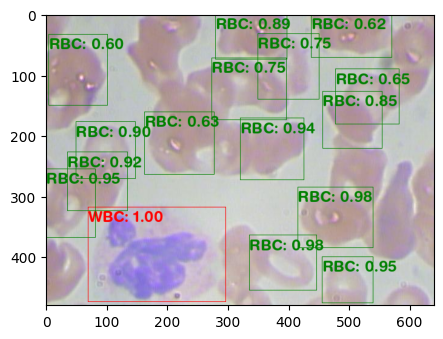

In [44]:
model.eval()

class_names = ['Background', 'WBC', 'RBC', 'Platelets']

with torch.no_grad():
    for i in test_images[:1]:
        image, target = dataset[i]
        outputs = model([image])
        image = dataset.get_image(i)
        draw = ImageDraw.Draw(image)
        classes = outputs[0]['labels'].cpu().numpy()
        scores = outputs[0]['scores'].cpu().numpy()
        boxes = outputs[0]['boxes'].cpu().numpy()

        for i, box in enumerate(boxes):
            if scores[i] > 0.5:
                classes[i] = classes[i] if classes[i] < 4 else 0
                class_name = class_names[classes[i]]
                cl = ['black', 'red', 'green', 'blue']
                draw.rectangle(xy=box.tolist(), outline=cl[classes[i]])
                font = ImageFont.truetype('Helvetica.otf', 25)
                draw.text((box[0], box[1]), f'{class_name}: {scores[i]:.2f}', fill=cl[classes[i]],
                          font = font)

        # Convert the PIL image back to a NumPy array for displaying with matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.show()